### Unbalanced Labels in the Regression Setting

When one referenced to unbalanced data they almost exclusively refer to it in the context of classification tasks where the label categories are not equally likely to be observed. The classification context is extremely common in genomics and has challenges that must be handled appropriately. However, a much less talked about setting is unbalanced data in the regression setting. Here, the distribution of continuous-valued labels is not the same between tasks. When models are trained that simply sum the loss across all tasks during training, tasks with lower-valued distributions tend to be ignored and those with higher-valued distributions are focused on. Unfortunately, this strategy of summing the loss across tasks is fairly common in built-in machine learning packages such as scikit-learn, and pretty much ubiquitous for deep learning frameworks. 

In [1]:
%pylab inline
import seaborn
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Let's start off with a simple example where we generate a synthetic data set of Gaussian random values with linear combinations, with some Gaussian noise added on top, being the labels. For one task the weights used in the linear combinations for one task will be drawn from ~N(0, 1) and the other task will have weights drawn from ~N(0, 10).

In [2]:
numpy.random.seed(0)

train_size, test_size = 200, 50

X = numpy.random.randn(train_size + test_size, 20)
w = numpy.random.randn(20, 2)
w[:,1] *= 10

Y = X.dot(w) + numpy.random.randn(X.shape[0], 2)

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

Let's look at the distributions of labels in the training set for the two tasks.

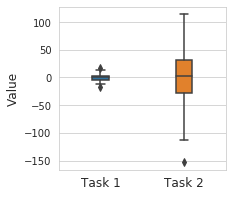

In [3]:
plt.figure(figsize=(3, 3))
ax = plt.subplot(111)

seaborn.boxplot(data=Y_train, ax=ax, width=0.2)
plt.ylabel("Value", fontsize=12)
plt.xticks([0, 1], ["Task 1", "Task 2"], fontsize=12)
plt.show()

Task 2 clearly has the larger dynamic range, going from around -100 to around 100.

How accurate is a model that only predicts Task 1? We will measure performance using the simple mean-squared-error.

In [4]:
from sklearn.ensemble import RandomForestRegressor

model1 = RandomForestRegressor()
model1.fit(X_train, Y_train[:,0])
X_hat1 = model1.predict(X_test)

((X_hat1 - Y_test[:,0]) ** 2).mean()

19.12268449181347

Now, let's see what happens when we train a model that predicts both Task 1 and Task 2 but we evaluate only it's ability to perform Task 1. The data and labels for Task 1 will remain the same---the only difference is that it's also making predictions for Task 2. 

In [5]:
model2 = RandomForestRegressor()
model2.fit(X_train, Y_train)
X_hat2 = model2.predict(X_test)[:,0]

((X_hat2 - Y_test[:,0]) ** 2).mean()

23.918498383095617

Looks like the error is much higher on Task 1 even though the data and labels are still there. That's because the model is trained to predict both tasks and the larger dynamic range of Task 2 causes the model to focus on it. How do we know that's the case? Let's decrease the weight of Task 2 and see what the error is.

In [6]:
numpy.random.seed(0)

X = numpy.random.randn(train_size + test_size, 20)
w = numpy.random.randn(20, 2)

Y = X.dot(w) + numpy.random.randn(X.shape[0], 2)

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

model1 = RandomForestRegressor()
model1.fit(X_train, Y_train[:,0])
X_hat1 = model1.predict(X_test)

model2 = RandomForestRegressor()
model2.fit(X_train, Y_train)
X_hat2 = model2.predict(X_test)[:,0]

print("Single Task Model MSE: {:5.5}".format(((X_hat1 - Y_test[:,0]) ** 2).mean()))
print("Multitask Model MSE: {:5.5}".format(((X_hat2 - Y_test[:,0]) ** 2).mean()))

Single Task Model MSE: 19.123
Multitask Model MSE: 17.143


When the two tasks have equal weight we see that the multitask model has a lower MSE than the single task model, potentially because it's able to use the second task as a regularization against noise.

Rather than focus on two weights, let's do a full scan and use several random initializations to make sure the effects of what we're seeing aren't due to noise.

In [7]:
def mse(X, Y):
    return ((X - Y) ** 2).mean()


mse1, mse2 = [], []

alphas = 10 ** numpy.arange(-4, 4.1, 0.5)
for alpha in alphas:
    mse1.append([])
    mse2.append([])
    
    for i in range(10):
        numpy.random.seed(i)

        X = numpy.random.randn(train_size + test_size, 20)
        w = numpy.random.randn(20, 2)
        w[:,1] *= alpha

        Y = X.dot(w) + numpy.random.randn(X.shape[0], 2)

        X_train, X_test = X[:train_size], X[train_size:]
        Y_train, Y_test = Y[:train_size], Y[train_size:]

        model1 = RandomForestRegressor()
        model1.fit(X_train, Y_train[:,0])

        model2 = RandomForestRegressor()
        model2.fit(X_train, Y_train)

        X_hat1 = model1.predict(X_test)
        X_hat2 = model2.predict(X_test)[:,0]

        mse1[-1].append(mse(X_hat1, Y_test[:,0]))
        mse2[-1].append(mse(X_hat2, Y_test[:,0]))

mse1 = numpy.array(mse1)
mse2 = numpy.array(mse2)

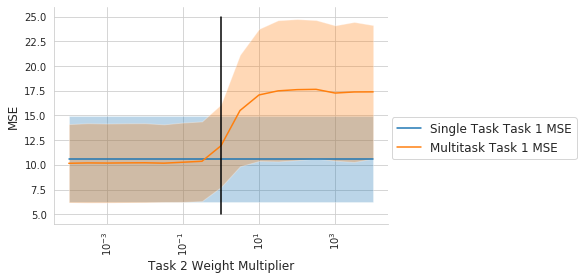

In [8]:
mu1, std1 = mse1.mean(axis=1), mse1.std(axis=1)
mu2, std2 = mse2.mean(axis=1), mse2.std(axis=1)

plt.plot(alphas, mu1, label="Single Task Task 1 MSE")
plt.plot(alphas, mu2, label="Multitask Task 1 MSE")
plt.plot([1, 1], [5, 25], color='k')

plt.fill_between(alphas, mu1-std1, mu1+std1, alpha=0.3)
plt.fill_between(alphas, mu2-std2, mu2+std2, alpha=0.3)

plt.xscale('log')
plt.xticks(rotation=90)
plt.xlabel("Task 2 Weight Multiplier", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.legend(fontsize=12, loc=(1.01, 0.3))

seaborn.despine()
plt.show()

We can clearly see here that there is an inflection point at the black line where the two tasks are equally weighted. On the left side of that plot, the single and multitask models achieve roughly the same MSE on Task 1. However, on the right hand side of the line, where Task 2 has a larger dynamic range than Task 1, the performance on Task 1 starts to rapidly decrease for the multitask model.

What does this have to do with biology? Well, the gist is that when you train a multitask model, the overall performance across all tasks may be a misleading performance measure. Overall performance will be dominated by tasks with the largest dynamic range. Indeed, as we see here, including tasks with varying dynamic ranges may actually caused the trained model to perform WORSE on the tasks with a smaller dynamic range because they comprise such a small part of the overall objective function.